In [1]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
from tqdm import tqdm


import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
DIR_PELVIS = os.path.join(os.getcwd(), "..", "data", "Task1", "pelvis")
HU_THRESHOLD = 2000

In [3]:
list_pelvis_image_dir = [os.path.join(DIR_PELVIS, f) for f in os.listdir(DIR_PELVIS) if f.startswith("1P")]

In [4]:
def process_one_ct(file):
    filepath = os.path.join(file, "ct.nii.gz")
    img = nib.load(filepath)
    data = np.asanyarray(img.dataobj, dtype=np.int16)  # speed up processing
    max_hu = np.max(data)
    if max_hu <= HU_THRESHOLD:
        slice_counts = 0
    else:
        # COUNT_CT_ABOVE_THRESHOLD += 1
        slice_counts = np.sum(np.any(data > HU_THRESHOLD, axis=(0, 1)))
    
    return {
        "id": file.split("/")[-1],
        "num_slices": data.shape[2],
        "HU_above_2000": slice_counts,
        "max_HU": max_hu
    }

In [5]:
ct_stats = []
COUNT_CT_ABOVE_THRESHOLD = 0

max_workers = os.cpu_count() // 8 # rolf: 128/8
with ProcessPoolExecutor(max_workers=max_workers) as ex:
    futures = [ex.submit(process_one_ct, f) for f in list_pelvis_image_dir]
    for fut in tqdm(as_completed(futures), total=len(futures)):
        res = fut.result()
        ct_stats.append({
            "id": res["id"],
            "num_slices": res["num_slices"],
            "HU_above_2000": res["HU_above_2000"],
            "max_HU": res["max_HU"]
        })
        COUNT_CT_ABOVE_THRESHOLD += res["HU_above_2000"]>0

df_stats = pd.DataFrame(ct_stats)

100%|██████████| 180/180 [00:11<00:00, 16.24it/s]


In [6]:
print("Statistics: ")
print(df_stats)
print(f"\nTotal CTs: {len(df_stats)}")
print(f"CTs with HU > {HU_THRESHOLD}: {COUNT_CT_ABOVE_THRESHOLD}")

# Save statistics
df_stats.to_csv("ct_hu_stats.csv", index=False)

Statistics: 
         id  num_slices  HU_above_2000  max_HU
0    1PA025         141             55    3000
1    1PA018         147              0    1518
2    1PA022         127              0    1465
3    1PA004         149              0    1458
4    1PA024         146              0    1503
..      ...         ...            ...     ...
175  1PC085         101              3    2836
176  1PC096          87              1    2781
177  1PC097          84              6    3000
178  1PC093          88              1    2761
179  1PC098         104              3    3000

[180 rows x 4 columns]

Total CTs: 180
CTs with HU > 2000: 111


In [7]:
df_stats.describe()

,num_slices,HU_above_2000,max_HU
count,180.000000,180.000000,180.000000
mean,116.844444,6.677778,2355.438889
std,23.028722,16.121278,671.029320
min,84.000000,0.000000,1389.000000
25%,92.750000,0.000000,1528.750000
50%,119.000000,2.000000,2721.500000
75%,139.000000,4.000000,3000.000000
max,153.000000,86.000000,3000.000000


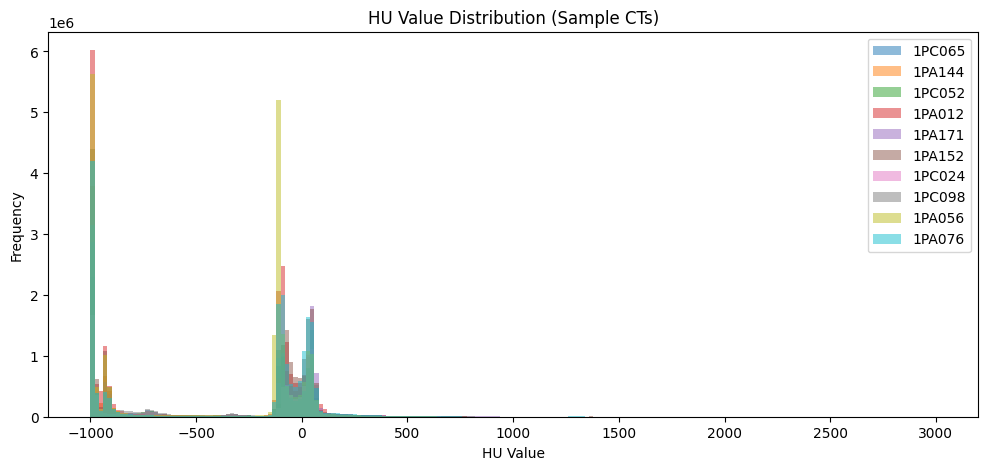

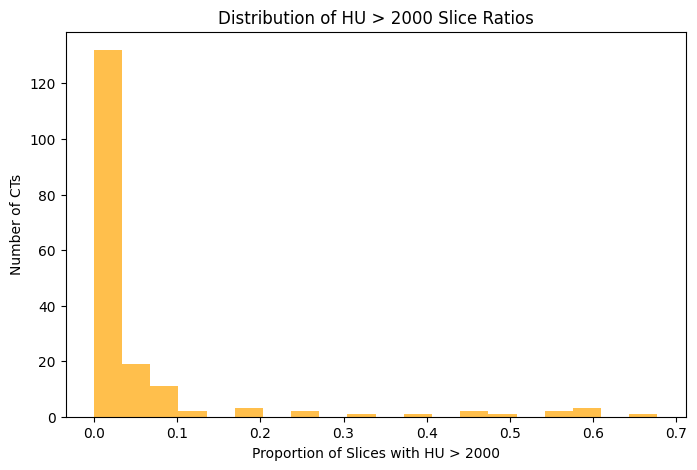

In [8]:
# Plotting the statistics
sample_ct = np.random.choice(df_stats["id"], size=10, replace=False)
plt.figure(figsize=(12, 5))
for ct_name in sample_ct:
    filepath = os.path.join(DIR_PELVIS, ct_name, "ct.nii.gz")
    img = nib.load(filepath)
    data = img.get_fdata().flatten()
    plt.hist(data, bins=200, alpha=0.5, label=ct_name, range=(-1000, 3000))
plt.xlabel("HU Value")
plt.ylabel("Frequency")
plt.title("HU Value Distribution (Sample CTs)")
plt.legend()
# plt.savefig("hu_distribution.png", dpi=300)
plt.show()

# 2. HU > 2000 
df_stats["ratio_HU_above_2000"] = df_stats["HU_above_2000"] / df_stats["num_slices"]
plt.figure(figsize=(8, 5))
plt.hist(df_stats["ratio_HU_above_2000"], bins=20, color="orange", alpha=0.7)
plt.xlabel("Proportion of Slices with HU > 2000")
plt.ylabel("Number of CTs")
plt.title("Distribution of HU > 2000 Slice Ratios")
# plt.savefig("high_hu_slice_ratio.png", dpi=300)
plt.show()


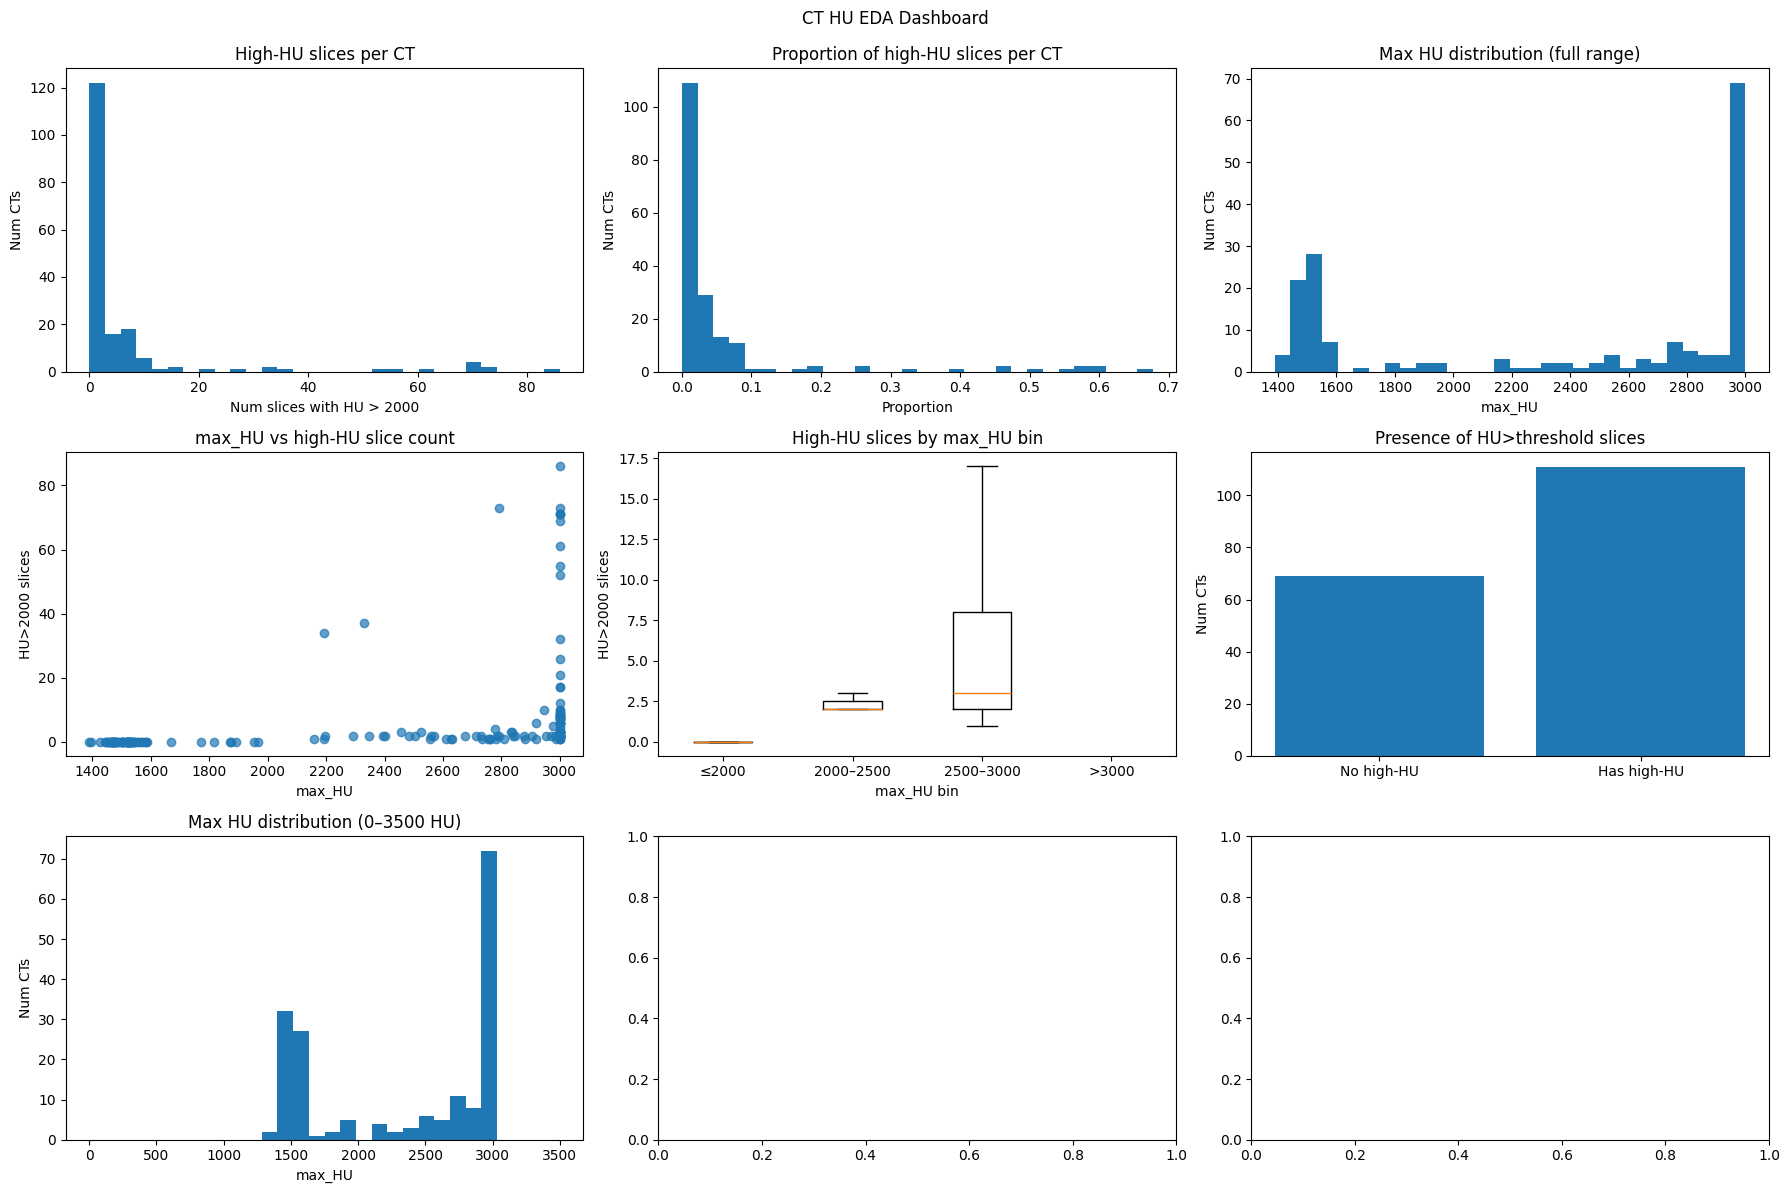

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# generated by gpt
def plot_ct_hu_dashboard(df: pd.DataFrame, threshold: int = 2000):
    # Check required columns
    required_cols = {"id", "num_slices", "HU_above_2000", "max_HU"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    df = df.copy()

    # Compute ratio of high-HU slices
    df["ratio_high_HU"] = (
        df["HU_above_2000"] / df["num_slices"]
    ).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Boolean flag: whether CT has any high-HU slices
    df["has_high_HU"] = df["HU_above_2000"] > 0

    # Bin max_HU values into categories
    bins = [0, 2000, 2500, 3000, np.inf]
    labels = ["≤2000", "2000–2500", "2500–3000", ">3000"]
    df["maxHU_bin"] = pd.cut(df["max_HU"], bins=bins, labels=labels, include_lowest=True, right=True)

    # Create figure with 3 rows × 3 columns (we will use 7 subplots)
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, _, _ = axes.ravel()

    # 1) Histogram: number of slices with HU > threshold
    ax1.hist(df["HU_above_2000"], bins=30)
    ax1.set_title("High-HU slices per CT")
    ax1.set_xlabel(f"Num slices with HU > {threshold}")
    ax1.set_ylabel("Num CTs")

    # 2) Histogram: proportion of high-HU slices
    ax2.hist(df["ratio_high_HU"], bins=30)
    ax2.set_title("Proportion of high-HU slices per CT")
    ax2.set_xlabel("Proportion")
    ax2.set_ylabel("Num CTs")

    # 3) Histogram: max_HU (full range)
    ax3.hist(df["max_HU"], bins=30)
    ax3.set_title("Max HU distribution (full range)")
    ax3.set_xlabel("max_HU")
    ax3.set_ylabel("Num CTs")

    # 4) Scatter plot: max_HU vs number of high-HU slices
    ax4.scatter(df["max_HU"], df["HU_above_2000"], alpha=0.7)
    ax4.set_title("max_HU vs high-HU slice count")
    ax4.set_xlabel("max_HU")
    ax4.set_ylabel(f"HU>{threshold} slices")

    # 5) Boxplot: high-HU slices grouped by max_HU bins
    grouped = [df.loc[df["maxHU_bin"] == lab, "HU_above_2000"].values for lab in labels]
    ax5.boxplot(grouped, showfliers=False)
    ax5.set_title("High-HU slices by max_HU bin")
    ax5.set_xlabel("max_HU bin")
    ax5.set_ylabel(f"HU>{threshold} slices")
    ax5.set_xticks(range(1, len(labels) + 1))
    ax5.set_xticklabels(labels)

    # 6) Bar chart: presence or absence of high-HU slices
    counts = df["has_high_HU"].value_counts().reindex([False, True]).fillna(0).astype(int)
    ax6.bar(["No high-HU", "Has high-HU"], counts.values)
    ax6.set_title("Presence of HU>threshold slices")
    ax6.set_ylabel("Num CTs")

    # 7) Histogram: max_HU (zoomed range)
    ax7.hist(df["max_HU"], bins=30, range=(0, 3500))
    ax7.set_title("Max HU distribution (0–3500 HU)")
    ax7.set_xlabel("max_HU")
    ax7.set_ylabel("Num CTs")

    fig.suptitle("CT HU EDA Dashboard", y=0.99)
    plt.tight_layout()
    plt.show()

plot_ct_hu_dashboard(df_stats, threshold=2000)
